In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Introduction

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1rnyzJHlBu3M2E3zeNO-2h_f7LdS5dJv0' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
# find data set at https://www.kaggle.com/mlg-ulb/creditcardfraud
downloaded.GetContentFile('creditcard.csv')  
data = pd.read_csv('creditcard.csv')

     |████████████████████████████████| 993kB 4.9MB/s 
1rnyzJHlBu3M2E3zeNO-2h_f7LdS5dJv0


In [0]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


0    284315
1       492
Name: Class, dtype: int64

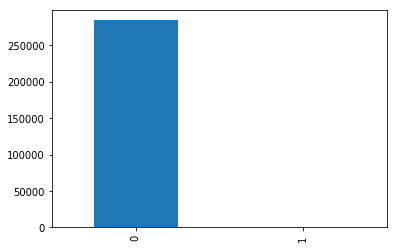

In [0]:
count = pd.value_counts(data['Class'], sort = True).sort_index()
count.plot(kind = 'bar')
count

The two classes are really imbalanced!

## Data Split

We will first split the data randomly into train and test sets to do exploratory analysis, while preserving the ratio of classes in each of them. 

In [0]:
from sklearn.model_selection import train_test_split
y = data['Class']
X = data.drop('Class',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=8125)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.333, stratify=y_train,random_state=8125)
train = pd.concat([X_train, y_train],axis=1)
validation = pd.concat([X_validate, y_validate],axis=1)
test = pd.concat([X_test, y_test],axis=1)
print("Percentage of fraud transactions in train is: ",round(train.Class.mean(),4))
print("Percentage of fraud transactions in test is: ",round(test.Class.mean(),4))

Percentage of fraud transactions in train is:  0.0017
Percentage of fraud transactions in test is:  0.0017


## EDA and Feature Engeneering

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,142228.0,94894.700214,47514.517604,0.0,54262.00,84845.5,139340.25,172792.0
1,246.0,78917.178862,47120.804097,406.0,41196.25,74647.5,110550.75,170348.0


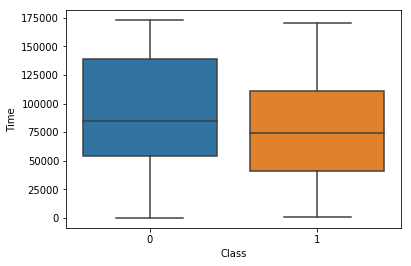

In [0]:
sns.boxplot(x="Class", y="Time",data=train)
train.groupby("Class").Time.describe()

Time itself doesn't seem to determine class well. We will feature a new variable which is the time difference between transaction and the precede transaction. In order to that, we will combine train and test first, do the feature engineering, then split the dataset again. 

In [0]:
data = pd.concat([train,validation,test],axis=0)
#the column names are auto reordered, lets turn it back to what it should be
data = data[list(train.columns.values)]
data.sort_index(inplace=True)
#create the time difference feature
data['Time_Difference'] = data['Time']-data['Time'].shift()
#remove the nan row caused by lag
data.dropna(axis=0,inplace=True)

#split the data set again
y = data['Class']
X = data.drop('Class',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=8125)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.333, stratify=y_train,random_state=8125)
train = pd.concat([X_train, y_train],axis=1)

In [0]:
train.groupby('Class').Time_Difference.describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,142227.0,0.605054,1.044713,0.0,0.0,0.0,1.0,32.0
1,246.0,1.138211,1.848663,0.0,0.0,1.0,1.0,12.0


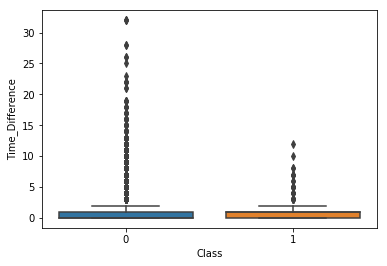

In [0]:
sns.boxplot(x="Class", y="Time_Difference",data=train)

Most of the time difference are similiar, however, some large difference might indicates fraud, as fraud often happens at time that has few transactions. 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


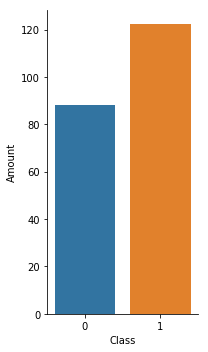

In [0]:
sns.factorplot(x="Class", y="Amount", data=train, kind="bar", ci=None, aspect=.6)

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,142227.0,88.078038,250.113191,0.0,5.69,22.000,77.0000,25691.16
1,246.0,122.171829,246.790034,0.0,1.00,10.145,112.1725,2125.87


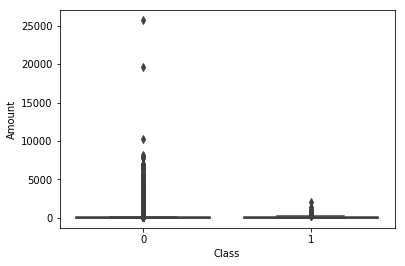

In [0]:
sns.boxplot(x="Class", y="Amount", data=train)
train.groupby('Class').Amount.describe()

Even though average amount of non-fraud is greater than fraud, transaction of large amount however are mostly fraud, which follows our instinct about fraud. We will create a binary factor indicating transaction with large amount, with a threshold of 2000. 

In [0]:
pd.options.mode.chained_assignment = None
def amount_threshold(x):
    if x > 2000: return 1
    else: return 0
    
X_train['Large_Amount'] = X_train['Amount'].apply(amount_threshold)
X_validate['Large_Amount'] = X_validate['Amount'].apply(amount_threshold)
X_test['Large_Amount'] = X_test['Amount'].apply(amount_threshold)

## Predict and Evaluate - Original set

We will first use logistic regression, with parameter tuned by stratified cross validation, to predict the probability of labels. We use area under Precision-Recall curve, aka average precision score to evaluate the performance. The reason to choose PR AUC over ROC AUC is that PR does not account for true negatives, therefore more suitable for imbalanced classification.

In [0]:
from sklearn.linear_model import LogisticRegressionCV
logCV = LogisticRegressionCV(Cs=[0.01,0.1,1,10,100], scoring='average_precision',verbose=0,
                             max_iter=200,random_state=5001)
logCV.fit(X_train,y_train)
print("The best parameter C is",logCV.C_[0])

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


The best parameter C is 1.0


We will then use the fitted model to predict our validation (test) set. The output would be a set of probabilities, which we will analyze it with respect to PR-curve.  

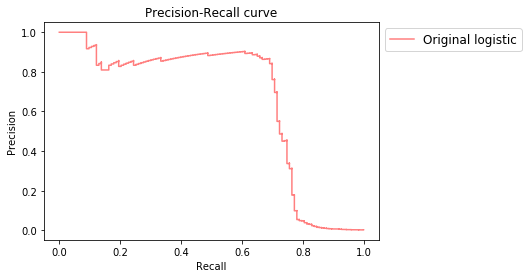

In [0]:
from sklearn.metrics import average_precision_score, precision_recall_curve
pred_prob = logCV.predict_proba(X_validate)
y_score = pred_prob[:,1]
average_precision = average_precision_score(y_validate, y_score)
original_precision, original_recall, original_thresholds = precision_recall_curve(y_validate, y_score)
plt.step(original_recall, original_precision, color='red', alpha=0.5,linewidth=1.5,label='Original logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize = 'large')

From the PR curve above we can see how our model performed, and we can choose optimised cutoff to yield the precision and recall rate we want. 

## Data Resampling

It's time to do some resampling to our train set! We will oversample our minority class with SMOTE(Synthetic Minority Over-sampling Technique), which generates new samples similiar but not typically identical of minority classes, since the algorithm takes nearby instances of same class into account. One important thing to mention is that we should NEVER resample our validation or test set, since it might lead to an over-optimistic performance that is untrustable. 

In [0]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=4001,kind='regular')
X_res, y_res = sm.fit_sample(X_train, y_train)
pd.value_counts(y_res)

1    142227
0    142227
dtype: int64

## Predict and Evaluate - Resampled set

Next we will use logistic regression with the same parameter C=10 to test the performance on our same validation(test) set. 

In [0]:
from sklearn.linear_model import LogisticRegression
log_res = LogisticRegression(C=10, verbose=0, random_state=5001)
log_res.fit(X_res,y_res)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=5001, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

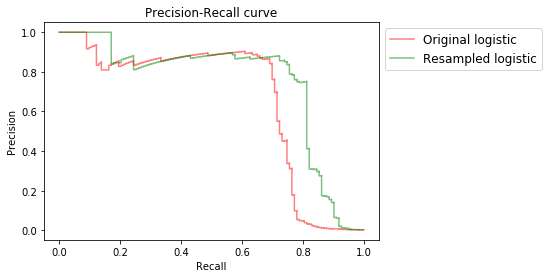

In [0]:
pred_prob = log_res.predict_proba(X_validate)
resampled_score = pred_prob[:,1]
average_precision = average_precision_score(y_validate, y_score)
resampled_precision, resampled_recall, resampled_thresholds = precision_recall_curve(y_validate, resampled_score)
plt.step(original_recall, original_precision, color='red', alpha=0.5,linewidth=1.5,label='Original logistic')
plt.step(resampled_recall, resampled_precision, color='green', alpha=0.5,linewidth=1.5,label='Resampled logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize = 'large')

We can see from the right of the plot that resampling does bring improvement to our model. Similiar precision rate now gives us a higher recall rate! Next we will approach with different models to see if we can make further improvement. 

## Random Forest - Resampled set

We will now train the well-known random forest algorithm on the resampled train set. Random forest usually have satisfying performance on classification problem, even without complicated model tuning. 

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=4, n_estimators=100, bootstrap=True, random_state=7017)
rf.fit(X_res,y_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=7017, verbose=0,
            warm_start=False)

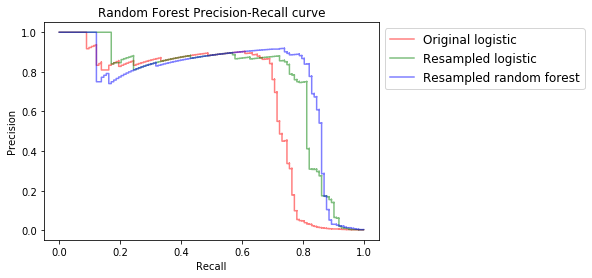

In [0]:
pred_prob = rf.predict_proba(X_validate)
rf_score = pred_prob[:,1]
average_precision = average_precision_score(y_validate, y_score)
rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_validate, rf_score)
plt.step(original_recall, original_precision, color='red', alpha=0.5,linewidth=1.5,label='Original logistic')
plt.step(resampled_recall, resampled_precision, color='green', alpha=0.5,linewidth=1.5,label='Resampled logistic')
plt.step(rf_recall, rf_precision, color='blue', alpha=0.5,linewidth=1.5,label='Resampled random forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest Precision-Recall curve')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize = 'large')

Comparing to logistic regression, random forest seems to be more suitable for our data, with another big improvement on validation set. 

## Cluster Before Prediction - Original set

We will aproach the problem in a different but intuitive way. The method is called cluster before prediction, with three consecutive steps. First separate the majority class into clusters, say 20 clusters. Then we will combine each segment with all minority samples to train 20 models. Finally, we predict the test set with these models, averaging all of them to get a final prediction. We will train random forest classifiers since it generates better result comparing to logistic regression.

In [0]:
from sklearn.cluster import KMeans
X_train_minority, X_train_majority = X_train[y_train==1], X_train[y_train==0]
kmeans = KMeans(n_clusters=20, random_state=5001).fit(X_train_majority)

kmeans.labels

In [0]:
prediction = [0]*len(X_validate)
for i in range(0,20):
        majority_segment = X_train_majority[kmeans.labels_==i]
        X_train_segment = pd.concat([majority_segment,X_train_minority])
        y_train_segment = [0]*len(majority_segment)+[1]*len(X_train_minority)
        rf = RandomForestClassifier(max_depth=4, n_estimators=100, bootstrap=True,random_state=7001)
        rf.fit(X_train_segment,y_train_segment)
        pred_prob = rf.predict_proba(X_validate)
        prediction = np.add(prediction, pred_prob[:,1])
prediction = prediction/20            

In [0]:
y_score = prediction
average_precision = average_precision_score(y_validate, y_score)
cls_precision, cls_recall, cls_thresholds = precision_recall_curve(y_validate, y_score)
plt.step(original_recall, original_precision, color='red', alpha=0.5,linewidth=1.5,label='Original logistic')
plt.step(resampled_recall, resampled_precision, color='green', alpha=0.5,linewidth=1.5,label='Resampled logistic')
plt.step(rf_recall, rf_precision, color='blue', alpha=0.5,linewidth=1.5,label='Resampled random forest')
plt.step(cls_recall, cls_precision, color='orange', alpha=0.5,linewidth=1.5,label='Clustered random forest')
plt.plot([0.81],[0.84],color="black",marker='o', markersize=5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')

plt.legend(loc='upper left', bbox_to_anchor=(1,1), fontsize = 'large')

The algorithm yields similiar result to training random forest on resampled set. However, the left part of the graph indicates big improvement on keeping high precision rate when recall rate is about 0.2 - 0.4. We will choose resampled random forest as our final model, since it takes less time to train than clustered random forest. The black point indicates the precision and recall rate we want, and we are going to find the optimised cut for that. 

## Threshold and Confusion Matrix

In [0]:
error = []
for recall, precision in zip(rf_recall, rf_precision):
    err = (recall-0.81)**2 + (precision-0.84)**2
    error.append(err)
error = np.asarray(error)
min_index = np.where(error==min(error))
opt_threshold = rf_thresholds[min_index]
"The optimised threshold is: {0:0.3f}".format(opt_threshold[0])

In [0]:
from sklearn.metrics import confusion_matrix
y_pred = [1 if x > opt_threshold else 0 for x in rf_score]
conf = confusion_matrix(y_validate,y_pred)
conf = pd.DataFrame(conf, range(2),range(2))
sns.heatmap(conf, annot=True, fmt='g', annot_kws={"size": 16})
plt.title('Confusion matrix for validation set')

## Predict on Test set

In [0]:
pred_prob = rf.predict_proba(X_test)
y_score = pred_prob[:,1]
y_pred = [1 if x > opt_threshold else 0 for x in y_score]
conf = confusion_matrix(y_test,y_pred)
conf = pd.DataFrame(conf, range(2),range(2))
sns.heatmap(conf, annot=True, fmt='g', annot_kws={"size": 16})
plt.title('Confusion matrix for prediction on test set')

Using our chosen model and threshold on test set, we yield similiar result comparing to the validation set. Well done!

## Conclusion

For this project we investigated whether resampling technique can bring improvement to model of imbalanced classification. From what I see, I believe that the answer is yes, however there are something I would like to mention additional to the analyis. 
    
    1. Tuning parameters of resampled model with cross validation can possibly improve our model, however, we should not do cv after oversampling or else the oversampled validation slice of each fold won't be a good estimate of test set. The proper steps to do cv for each fold is to first select a validation set and leave it unchanged, oversample the remain data, and finally test the trained model on unchanged validation set. 
    2. There are other oversample techniques such as ROSE that we didn't try but can possibly improve our model. Undersampling techniques might be a suitable choice too. 
    3. In real world situation, the optimised point depends. Sometimes the cost of allowing more false positive is a lot cheaper than the loss of not identifying the positive ones. In such case, we can lower our precision to gain more recall.